In [1]:
# Les importations
import pandas as pd
from sqlalchemy import create_engine
from rapidfuzz import fuzz
from collections import Counter
import numpy as np


In [2]:
### valeurs constantes --------------
thr_similarity = 90


# ******************************************************

### Les fonctions ---------------

def mostCommon(lst):
    # cette fonction renvoie les valeurs les plus courantes (de chaque colonne) dans une liste de listes
    return [Counter(col).most_common(1)[0][0] for col in zip(*lst)]

# *******************************************************
def is_same(r1, r2):
    # cette fonction prend deux enregistrements et retourne true s'ils sont similaires
    # similarité: utilisation du NLP (Fuzzy string matching)

    return fuzz.token_sort_ratio(r1, r2) > thr_similarity

# *******************************************************

def detect_duplicates(df_p, df_pcr):
    # cette fonction prend une dataframe comme paramètre et retourne une nouvelle dataframe après avoir supprimé les doublons

    # ajouter une colonne, indiquant si cet enregistrement est vérifié ou non
    df_p['checked'] = False

    # convertir en liste et dict
    list_df_patient = df_patient.astype(str).values.tolist()
    dict_df_pcr = df_pcr.set_index('patient_id')['pcr'].to_dict()

    new_df = pd.DataFrame(columns=df_patient.columns)
    new_df['pcr'] = ''
    
    # id des enregistrements dupliqués
    id_of_dup_records = []

    for index in range(0, len(list_df_patient)):

        # s'il a été vérifié avant
        if list_df_patient[index][-1] == 'True':
            continue

        # nous vérifions ce dossier
        list_df_patient[index][-1] = 'True'

        r1 = list_df_patient[index]

        # créer un dataframe temporaire contenant tous les enregistrements similaires avec r1
        df_tmp = [r1]

        # création d'une liste contenant l'ID ('patient_id') de tous les enregistrements similaires
        l_patient_id = [list_df_patient[index][0]]

        # pour index2, r2 dans df_p.iterrows ():
        for index2 in range(index + 1, len(list_df_patient)):

            # s'il a été vérifié avant
            if list_df_patient[index2][-1] == 'True':
                continue

            r2 = list_df_patient[index2]

            # si r1 et r2 sont similaires
            if is_same(str(list_df_patient[index][1:]), str(list_df_patient[index2][1:])):
                # nous vérifions ce dossier
                list_df_patient[index2][-1] = 'True'

                # ajouter l'ID à la liste
                l_patient_id.append(list_df_patient[index2][0])

                # ajouter r2 à df_tmp
                df_tmp.append(r2)
                
                # enregistrer l'id de l'enregistrement dupliqué
                id_of_dup_records.append(list_df_patient[index2][0])

        # trouver la vraie valeur pcr pour l'enregistrement actuel (à partir des données pcr)
        list_found_pcr = [dict_df_pcr.get(int(x)) for x in l_patient_id if dict_df_pcr.get(int(x))]
        if not list_found_pcr:  # s'il n'y a pas de pcr pour le patient_id
            pcr = 'NaN'
            patient_id = l_patient_id[0]
        else:
            pcr = max(set(list_found_pcr), key=list_found_pcr.count)
            patient_id = [x for x in l_patient_id if dict_df_pcr.get(int(x)) == pcr][0]

        # maintenant à partir de tous les enregistrements similaires, choisissez le plus courant et remplacez-le par r1 (supprimez r1 et ajoutez le plus courant)
        adding_data = pd.DataFrame(df_tmp, columns=df_p.columns)
        adding_data = adding_data.mode().iloc[0, :]
        adding_data['pcr'] = pcr
        adding_data['patient_id'] = int(patient_id)

        new_df = new_df.append(adding_data)

    new_df = new_df.drop(columns=['checked'])
    new_df = new_df.reset_index(drop=True)
    return new_df, id_of_dup_records


In [3]:
### Le code principal commence à partir d'ici ---------------

# lire les dataframes
engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

In [4]:
# conversion de N en négatif (et P en positif) dans la trame de données df_pcr
df_pcr[df_pcr['pcr']=='N'] = 'Negative'
df_pcr[df_pcr['pcr']=='P'] = 'Positive'

In [5]:
# vérifier si df_pcr a tous les bons patients_id (devrait être numérique)
df_pcr.patient_id.astype(str).str.isnumeric().all()
# donc nous avons un mauvais identifiant dans df_pcr

False

In [6]:
# conserver la taille totale initiale des dataframes
total_size_pcr = len(df_pcr)
total_size_patient = len(df_patient)

# patient_id initial
patient_ids = df_patient['patient_id']

In [7]:
# nettoyer df_pcr de la chaîne patient_id
num_of_bad_p_id_pcr = len(df_pcr[~df_pcr.patient_id.astype(str).str.isnumeric()])

# nettoyer df_pcr du mauvais identifiant
df_pcr = df_pcr[df_pcr.patient_id.astype(str).str.isnumeric()]

# trouver le patient_id dupliqué dans df_pcr et vérifier s'ils ont le même pcr ou non
# ajouter l'id à la liste des conflits de pcr si les valeurs pcr ne sont pas les mêmes
p_id_conflict_pcr = []
df_pcr_dup_id = df_pcr[(df_pcr.duplicated(subset='patient_id'))]['patient_id']
for p_id in df_pcr_dup_id.values:
    tmp = df_pcr[df_pcr['patient_id'] == p_id]
    if (not tmp.empty) and (tmp.pcr.nunique() > 1):
        p_id_conflict_pcr.append(p_id)

# soustraire les identifiants de conflit de l'identifiant en double
df_pcr_dup_id = df_pcr_dup_id[~df_pcr_dup_id.isin(p_id_conflict_pcr)]

# nous supprimons le patient_id en conflit
df_pcr = df_pcr.drop(df_pcr[df_pcr.patient_id.isin(p_id_conflict_pcr)].index)
# déposer l'un des patients_id dupliqués (nous en gardons un)
df_pcr = df_pcr.drop_duplicates(subset='patient_id')

df_pcr

,patient_id,pcr
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative
6,169224,Negative
...,...,...
8792,270457,Negative
8793,658692,Negative
8796,279689,Positive
8798,884429,Positive


In [8]:
# trouver le patient_id dupliqué dans df_patient et vérifier s'il s'agit du même patient ou non
# ajouter l'identifiant à la liste de conflits (du patient) si le patient n'est pas le même
p_id_conflict_patient = []
df_patient_dup_id = df_patient[(df_patient.duplicated(subset='patient_id'))]['patient_id']

for p_id in df_patient_dup_id.values:

    tmp = df_patient[df_patient['patient_id'] == p_id]
    r1 = str(tmp.values[0, 1:])
    
    for i in range(1, len(tmp)):
        r2 = str(tmp.values[i, 1:])
        if not is_same(r1, r2):
            p_id_conflict_patient.append(p_id)
            break

# soustraire les identifiants de conflit de l'identifiant en double
df_patient_dup_id = df_patient_dup_id[~df_patient_dup_id.isin(p_id_conflict_patient)]

# nous supprimons le patient_id en conflit
df_patient = df_patient.drop(df_patient[df_patient.patient_id.isin(p_id_conflict_patient)].index)
num_conflict_duplicated_records = total_size_patient - len(df_patient)

# pas besoin de supprimer l'identifiant en double car il n'y a pas d'identifiant patient en double
# à la place, nous trouvons et supprimons les enregistrements dupliqués (compte tenu des fautes de frappe)

In [9]:
# recherche et nettoyage des doublons à partir du dataframe patient
df_patient_cleaned , id_dup_records_patient = detect_duplicates(df_patient, df_pcr)
# cette fonction prend du temps alors n'hésitez pas à prendre un café (pour moi ça prend environ 2h)
df_patient_cleaned

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,pcr
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella,NaN
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown,Negative
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None,NaN
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane,NaN
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18893,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,nan,02 92489054,glenmore,NaN
18894,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,07 20549476,None,NaN
18895,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,nan,26.0,03 83466737,None,NaN
18896,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,04 41125514,None,NaN


In [10]:
# informations de ces données
total_dup_records_df_patient = len(id_dup_records_patient)
total_records_with_pcr = len(df_patient_cleaned[df_patient_cleaned.pcr != 'NaN'])
total_positives = len(df_patient_cleaned[df_patient_cleaned.pcr == 'Positive'])
total_negatives = len(df_patient_cleaned[df_patient_cleaned.pcr == 'Negative'])
positive_percentage = total_positives * 100 / total_records_with_pcr
negative_percentage = total_negatives * 100 / total_records_with_pcr

print('Total number of records in df_patient: ', total_size_patient)
print('Total number of records in df_pcr: ', total_size_pcr)
print('****************************')
print('Total number of conflict duplicated patient_id in df_patient (the duplicated id with different patient) : ', len(p_id_conflict_patient))
print('Total number of duplicate records in df_patient (with typos): ', total_dup_records_df_patient)
print('****************************')
print('Total number of wrong records in df_pcr (bad patient_id) : ', num_of_bad_p_id_pcr)
print('Total number of conflict duplicated patient_id in df_pcr (the duplicated id with different pcr value) : ', len(p_id_conflict_pcr))
print('Total number of duplicated records in df_pcr : ', len(df_pcr_dup_id))
print('****************************')
print('Total number of records in df_patient which have pcr lable (after cleaning): ', total_records_with_pcr)
print('Total number of positive cases: ', total_positives)
print('percentage of positive cases: %.2f%%'% positive_percentage)

print('Total number of negative cases: ', total_negatives)
print('percentage of negative cases: %.2f%%'% negative_percentage)

Total number of records in df_patient:  20000
Total number of records in df_pcr:  8800
****************************
Total number of conflict duplicated patient_id in df_patient (the duplicated id with different patient) :  202
Total number of duplicate records in df_patient (with typos):  699
****************************
Total number of wrong records in df_pcr (bad patient_id) :  4383
Total number of conflict duplicated patient_id in df_pcr (the duplicated id with different pcr value) :  6
Total number of duplicated records in df_pcr :  7
****************************
Total number of records in df_patient which have pcr lable (after cleaning):  4290
Total number of positive cases:  1253
percentage of positive cases: 29.21%
Total number of negative cases:  3037
percentage of negative cases: 70.79%


In [11]:
# Les identifiants en conflit dans le DataFrame du patient
print(p_id_conflict_patient)

[119816, 328071, 521818, 844149, 411955, 289139, 645735, 303196, 441383, 692632, 212217, 251094, 159500, 912395, 427069, 125939, 428821, 512755, 436199, 470608, 483152, 272502, 517216, 261081, 477844, 628036, 875723, 832722, 223099, 670706, 428821, 651216, 250653, 994235, 338009, 870644, 655839, 124354, 835716, 732543, 601946, 964950, 882119, 448951, 488227, 721781, 975512, 365976, 513532, 872838, 728889, 461417, 264404, 442962, 914468, 682092, 666134, 756884, 967461, 839945, 990695, 124502, 942000, 781509, 935544, 974506, 492573, 260381, 476826, 610491, 646707, 325121, 735311, 799495, 910658, 527709, 829992, 621998, 958379, 952224, 990936, 378910, 601608, 392926, 566152, 110207, 169519, 817116, 481050, 985155, 562326, 853158, 479989, 733676, 404359, 852254, 223182, 472598, 446874, 402788, 521280, 633008, 304580, 191865, 638314, 195028, 354043, 966651, 431356, 741404, 594509, 579336, 799438, 109304, 931460, 914892, 924255, 696822, 227309, 659119, 374535, 779290, 394067, 723756, 957342,

In [14]:
# Les identifiants dupliqués dans le DataFrame du patient
print(id_dup_records_patient)

['246649', '316454', '923851', '497686', '500686', '385195', '438767', '226745', '683984', '786268', '378652', '218558', '722995', '565992', '160545', '704008', '243704', '535165', '103089', '863277', '293510', '268616', '138712', '604840', '144331', '915131', '599097', '901619', '401841', '185178', '808387', '950122', '399260', '776651', '184294', '606399', '688879', '781879', '351671', '192019', '776278', '761034', '714985', '661133', '221789', '869217', '978087', '759390', '162292', '340011', '549916', '955783', '764471', '584469', '684326', '424912', '375877', '613611', '550281', '812932', '235639', '585260', '472332', '131139', '101620', '497751', '571426', '394786', '180294', '622710', '207524', '836618', '521863', '437054', '765491', '281413', '141954', '152428', '676231', '987278', '421721', '202903', '287486', '238286', '828993', '369637', '657749', '136509', '908985', '616187', '370170', '135709', '669354', '909797', '529385', '186928', '374336', '890074', '853753', '220263',

In [15]:
# changer le type des colonnes (parce que nous avons utilisé la liste, elles sont toutes changées en objet) pour la visualisation
df_patient_cleaned = df_patient_cleaned.astype({"age": float, "street_number":float, "patient_id":np.int64, "date_of_birth": float})
df_patient_cleaned["state"].replace({"None": float('NaN')}, inplace=True)

Text(0, 0.5, 'Number of positives')

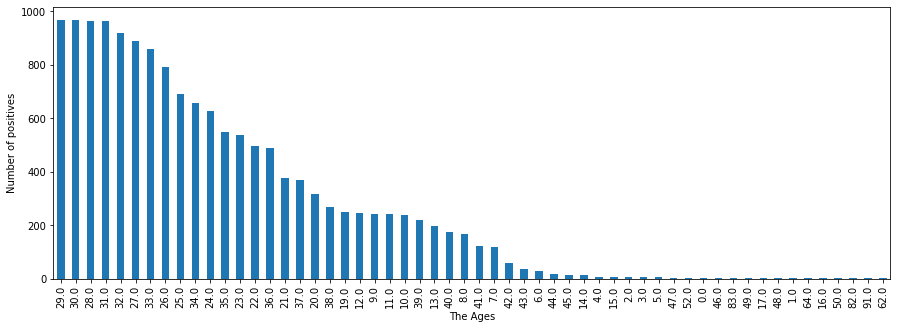

In [17]:
### visualiser les statistiques

# nombre de patients positifs pour Covid19 par âge
ax = df_patient_cleaned['age'].value_counts().plot(kind='bar', figsize=(15,5))
ax.set_xlabel("The Ages")
ax.set_ylabel("Number of positives")

Text(0, 0.5, 'The number of positives')

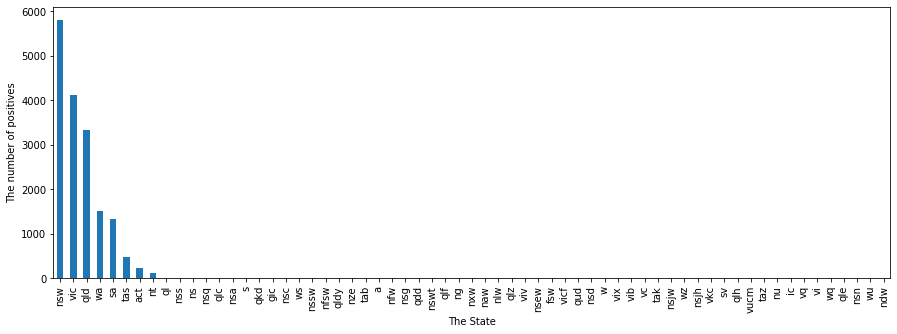

In [18]:
# nombre de patients positifs pour Covid19 par état (situation géographique)
ax = df_patient_cleaned['state'].value_counts().plot(kind='bar', figsize=(15,5))
ax.set_xlabel("The State")
ax.set_ylabel("The number of positives")